# deeptrack.features

<a href="https://colab.research.google.com/github/DeepTrackAI/DeepTrack2/blob/develop/tutorials/3-advanced-topics/DTAT301_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install deeptrack  # Uncomment if running on Colab/Kaggle.

This advanced tutorial introduces the module deeptrack.features.

In [2]:
from matplotlib import pyplot as plt
import numpy as np

## 1. What is a feature?

Features are instances of the abstract class `Feature` and are responsible for creating and altering images. For example, a feature might add a particle or add some salt-and-pepper noise to an image.

All features operate on lists of images (which can be either `Image` objects or numerical arrays). Most features, such as noise, apply some tranformation to all images in the list. This transformation can be additive, such as adding some Gaussian noise or a background illumination, or non-additive, such as introducing Poisson noise or performing a low-pass filter. This transformation is defined by the method `get(image, **kwargs)`, which all implementations of the class `Feature` need to define.

Some features, for example scatterers, instead, append a new image to the list. This behavior is controlled by the class attributes `__distributed__` and `__list_merge_strategy__`:

- `__distributed__` controls whether `.get(image, **kwargs)` is called on each element in the list separately (`__distributed__ = True`), or it is called on the list as a whole (`__distributed__ = False`).  

- `__list_merge_strategy__` controls how the output of `.get(image, **kwargs)` is merged with the input list. It can be `MERGE_STRATEGY_OVERRIDE` (`0`, default), where the new list is output without merging with the input, or `MERGE_STRATEGY_APPEND` (`1`), where the new list is appended to the end of the input list.

When a feature is created, keyword arguments can be passed to its constructor. These arguments are stored as properties (as a `PropertyDict`) of the feature (see also [properties_example](properties_example.ipynb)), which determine how the feature is resolved. When a feature is updated using the method `.update()`, all properties are updated by calling their respective methods `.update()`. When a feature is called, the current values of all properties are sent through the method `get(image, **kwargs)` as keyword arguments.

In [3]:
from deeptrack.features import Feature

class Foo(Feature):
    """Simple feature.
    
    Implementation of abstract class Feature which does not alter the input
    image and prints the current value of my_property.

    """

    # Controls what is passed to the method get(): 
    # False: everything is passed without modification.
    # True: elements along the first axis are passed separately to the images.
    __distributed__ = False

    def get(self, image, my_property=None, **kwargs):
        print(f"The current value of my_property is {my_property}")
        return image

In [4]:
foo1 = Foo(my_property=1)
foo1.update()
output_image = foo1()
print(output_image)

The current value of my_property is 1
[]


In [5]:
foo2 = Foo(my_property="bar")
foo2.update()
output_image = foo2()
print(output_image)

The current value of my_property is bar
[]


In [6]:
foo3 = Foo()
foo3.update()
output_image = foo3()
print(output_image)

The current value of my_property is None
[]


Since the values are stored as instances of the class `Property`, you can always replace values with standard structures (e.g., lists or lambda functions) to create more complex behaviors (see also [properties_example](properties_example.ipynb)).

In [7]:
foo4 = Foo(my_property=lambda: np.random.rand() - 0.5)
foo4.update()
output_image = foo4()
print(output_image)

The current value of my_property is 0.1209843758525152
[]


In [8]:
# Pick one random element from the list.
foo5 = Foo(my_property=lambda: np.random.choice(["bar", "baz"]))
foo5.update()
output_image = foo5()
print(output_image)

The current value of my_property is bar
[]


## 2. Operations Defined on Features

Features can be combined to create a feature series, which is a series of features that are evaluated sequentially.

### Chaining features (>>)

The rshft operator (>>) combines two features such that they are evaluated sequentially. For example, given the features `foo` and `bar`, you can combine them as `foobar = foo >> bar`. When `foobar` resolves an image, it first resolves an image from `foo`, then uses this image as the input to resolve an image from `bar`.

This operation returns an instance of the feature `Branch`, which contains the two features.

In [9]:
foobar = Foo(my_property="foo") >> Foo(my_property="bar")

foobar.update()
output_image = foobar()
print(output_image)

The current value of my_property is foo
The current value of my_property is bar
[]


### Repeating a feature (^) 

The xor operator (^) takes a feature `foo` and an integer `i` and creates a feature which will call the feature `i` times with different sets of properties. For example, `foo ^ 5` will call Foo five times. Since this is done at resolve time, the exponent can be any expression that returns an integer when evaluated.

This operation returns an instance of the feature `Repeat`, which contains the original feature and the number of times it should be repeated.

In [10]:
foo = Foo(my_property=lambda: np.random.choice(["bar", "baz", "qux", "quux"])) 

five_foos = foo ^ 5
five_foos.update()
output_image = five_foos()
print(output_image)

The current value of my_property is bar
The current value of my_property is bar
The current value of my_property is quux
The current value of my_property is quux
The current value of my_property is bar
[]


In [11]:
number_of_foo = lambda: np.random.randint(0, 10)
random_foos = foo ^ number_of_foo  # Pick one random exponent from the list.

random_foos.update()
output_image = random_foos()
print(output_image)

[]


## 3. Example - Image with Random Circles

Simple example that generates an image with some random circles.

In [12]:
class Circle(Feature):
    """Feature that adds a circle to the image."""

    def get(self, image, position, radius, intensity, **kwargs):
        X, Y = np.meshgrid(np.arange(image.shape[0]),
                           np.arange(image.shape[1]))
        mask = (X - position[0]) ** 2 + (Y - position[1]) ** 2 < radius ** 2
        image[mask] = intensity
        return image

In [13]:
circle = Circle(
    position=lambda: np.random.rand(2) * 512,
    radius=lambda: 20 + np.random.rand() * 20,
    intensity=1,
)

In [14]:
circles = circle ^ 10  # Add 10 circles.

In [15]:
circles.update()

input_image = np.zeros((512, 512))

output_image = circles.resolve(input_image)

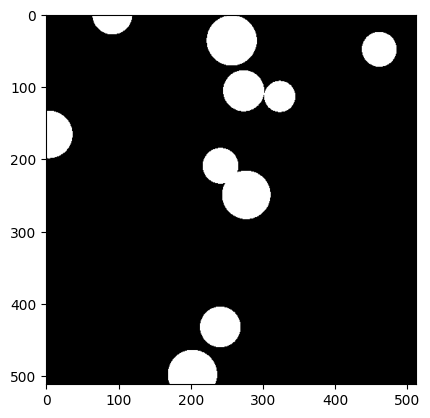

In [16]:
plt.imshow(output_image, cmap="gray")
plt.show()

## 4. Example - Image with Stacked Circles

And now a more complex example. In this case, we have a repeated feature that depends on another feature.

In [17]:
circle1 = Circle(
    position=lambda: np.random.rand(2) * 512,
    radius=lambda: 20 + np.random.rand() * 20,
    intensity=1,
)

In [18]:
# Add a circle with 2/3 the radius and 2 times the intensity of circle1.
circle2 = Circle(
    position=circle1.position,
    radius=circle1.radius * 0.66,
    intensity=circle1.intensity * 2,
)

In [19]:
# Add a circle with 1/3 the radius and 3 times the intensity of circle1.
circle3 = Circle(
    position=circle1.position,
    radius=circle1.radius * 0.33,
    intensity=circle1.intensity * 3,
)

In [20]:
stacked_circles = circle1 >> circle2 >> circle3

In [21]:
many_stacked_circles = stacked_circles ^ (lambda: np.random.randint(5, 10))
    

In [22]:
input_image = np.zeros((512, 512))

output_image = many_stacked_circles.update()(input_image) 

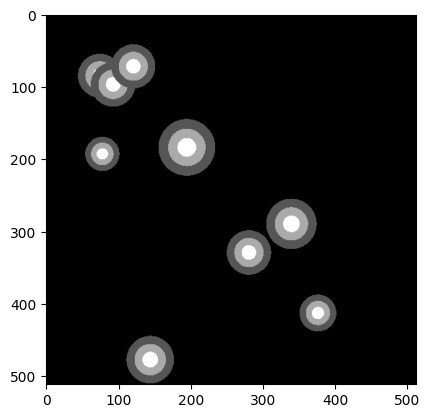

In [23]:
plt.imshow(output_image, cmap="gray")
plt.show()